# Import Libraries

In [1]:

import plotly.express as px
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt


# Read Data

In [2]:

# Load the data
#from google.colab import files
#uploaded = files.upload()
#df2 = pd.read_csv(io.BytesIO(uploaded['data.csv']))
E_data = pd.read_csv('/kaggle/input/ecomkyc/data.csv', encoding='unicode_escape')

# Perform Exploratory Data Analysis

In [3]:
E_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
#checking for data missing 
E_data.isnull().sum(axis=0)

 InvoiceNo          1
StockCode           1
Description      1455
Quantity            1
InvoiceDate         1
UnitPrice           1
CustomerID     135081
Country             1
dtype: int64

In [5]:
E_data.shape

(541910, 8)

In [6]:
#checking for negative values in quantity
E_data.Quantity.min()

-80995.0

In [7]:
E_data=E_data.drop_duplicates()
E_data.shape

(536642, 8)

In [8]:
# Perform data cleaning and transformation
E_data = E_data[pd.notnull(E_data['CustomerID'])]
#Check for Negative Values
E_data = E_data[(E_data['Quantity']>0)]
E_data['InvoiceDate'] = pd.to_datetime(E_data['InvoiceDate'])
# Add Total amount Column
E_data['TotalAmount'] = E_data['Quantity'] * E_data['UnitPrice']


In [9]:
#Customer distribution by country
country_cust_data=E_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3921
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


# Calculate Recency

In [10]:
recency = E_data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = recency['LastPurchaseDate'].max()
recency['Recency'] = recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


# Calculate Frequency

In [11]:
E_data.get("InvoiceNo ")
frequency = E_data.groupby(by='CustomerID', as_index=False)[' InvoiceNo'].count()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


# Calculate Monetary 

In [12]:
monetary = E_data.groupby(by='CustomerID', as_index=False)['TotalAmount'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Create RFM

In [13]:
RF = recency.merge(frequency, on='CustomerID')
RFM = RF.merge(monetary, on='CustomerID').drop(columns='LastPurchaseDate')

RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#This will ignore all DeprecationWarning warnings in your code.

# Plot R F M

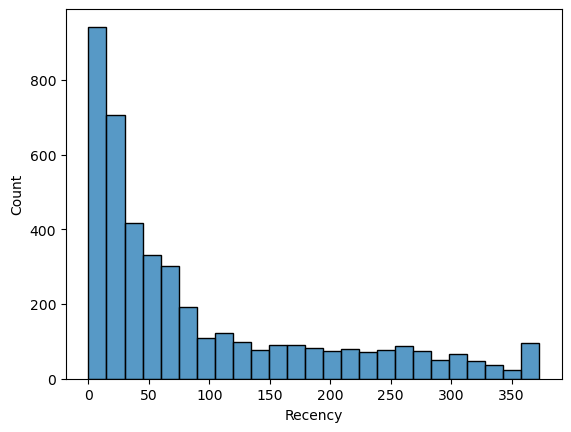

In [15]:
# Ploting R F M
Recency_Plot = recency['Recency']
ax = sns.histplot(Recency_Plot)


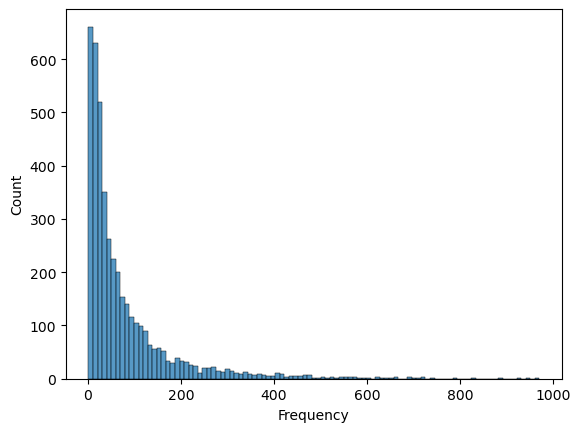

In [16]:
Frequency_Plot = frequency.query('Frequency < 1000')['Frequency']
ax = sns.histplot(Frequency_Plot)

# Apply Log Transformation

In [17]:
#Handle negative and zero values to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num

In [18]:
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFM['Recency'] = [handle_neg_n_zero(x) for x in RFM.Recency]
RFM['Monetary'] = [handle_neg_n_zero(x) for x in RFM.Monetary]
Log_Tfd_Data = RFM[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)


# Data After Normalized

In [19]:
#Data distribution after data normalization for Recency
#Recency_Plot = Log_Tfd_Data['Recency']
#ax = sns.histplot(Recency_Plot)
Recency_Plot = Log_Tfd_Data['Recency']
fig1 = px.histogram(Recency_Plot, nbins=50, opacity=0.9, marginal='rug', title='Recency distribution')
fig1.show()


In [20]:
#Data distribution after data normalization for Frequency
#Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
#ax = sns.histplot(Frequency_Plot)
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
fig2 = px.histogram(Frequency_Plot, nbins=50, opacity=0.7, marginal='rug', title='Frequency distribution')
fig2.show()

In [21]:
#Data distribution after data normalization for Monetary
#Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
#ax = sns.histplot(Monetary_Plot)
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
fig3 = px.histogram(Monetary_Plot, nbins=50, opacity=0.7, marginal='rug', title='Monetary distribution')
fig3.show()

# Descriptive Statistics for R F M

In [22]:
#Descriptive Statistics (Recency)
RFM.Recency.describe()

count    4339.000000
mean       91.539756
std        99.990232
min         1.000000
25%        17.000000
50%        50.000000
75%       141.000000
max       373.000000
Name: Recency, dtype: float64

In [23]:
#Descriptive Statistics (Frequency)
RFM.Frequency.describe()


count    4339.000000
mean       90.512100
std       225.515328
min         1.000000
25%        17.000000
50%        41.000000
75%        98.000000
max      7676.000000
Name: Frequency, dtype: float64

In [24]:
#Descriptive Statistics (Monetary)
RFM.Monetary.describe()

count      4339.000000
mean       2048.216154
std        8984.248299
min           1.000000
25%         306.455000
50%         668.560000
75%        1660.315000
max      280206.020000
Name: Monetary, dtype: float64

# Split into Four Segments

In [25]:
#Split into three segments using quantiles
quantiles = RFM.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()


In [26]:
quantiles

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 306.455, 0.5: 668.5600000000001, 0.75: 1660.315}}

In [27]:
 #Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [28]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFM['R'] = RFM['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFM['F'] = RFM['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFM['M'] = RFM['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,325,1,77183.60,4,4,1
1,12347.0,1,182,4310.00,1,1,1
2,12348.0,74,31,1797.24,3,3,1
3,12349.0,18,73,1757.55,2,2,1
4,12350.0,309,17,334.40,4,4,3


In [29]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFM['RFMGroup'] = RFM.R.map(str) + RFM.F.map(str) + RFM.M.map(str)
#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFM['RFMScore'] = RFM[['R', 'F', 'M']].sum(axis = 1)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12347.0,1,182,4310.00,1,1,1,111,3
2,12348.0,74,31,1797.24,3,3,1,331,7
3,12349.0,18,73,1757.55,2,2,1,221,5
4,12350.0,309,17,334.40,4,4,3,443,11


#  Divide Customers according to their loyalty

In [30]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver','Bronze']
Score_cuts = pd.qcut(RFM.RFMScore, q = 4, labels = Loyalty_Level)
RFM['RFM_Loyalty_Level'] = Score_cuts.values
RFM.reset_index().head(20)

,index,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,1,12347.0,1,182,4310.00,1,1,1,111,3,Platinum
2,2,12348.0,74,31,1797.24,3,3,1,331,7,Gold
3,3,12349.0,18,73,1757.55,2,2,1,221,5,Platinum
4,4,12350.0,309,17,334.40,4,4,3,443,11,Bronze
5,5,12352.0,35,85,2506.04,2,2,1,221,5,Platinum
6,6,12353.0,203,4,89.00,4,4,4,444,12,Bronze
7,7,12354.0,231,58,1079.40,4,2,2,422,8,Gold
8,8,12355.0,213,13,459.40,4,4,3,443,11,Bronze
9,9,12356.0,22,59,2811.43,2,2,1,221,5,Platinum


In [31]:
RFM['RFM_Loyalty_Level'].value_counts()

Gold        1332
Platinum    1263
Silver       975
Bronze       769
Name: RFM_Loyalty_Level, dtype: int64

In [32]:
#Validate the data for RFMGroup = 111
RFM[RFM['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)


,index,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,1690,14646.0,1,2080,280206.02,1,1,1,111,3,Platinum
1,4202,18102.0,1,431,259657.30,1,1,1,111,3,Platinum
2,3729,17450.0,7,336,194390.79,1,1,1,111,3,Platinum
3,1880,14911.0,1,5672,143711.17,1,1,1,111,3,Platinum
4,1334,14156.0,9,1395,117210.08,1,1,1,111,3,Platinum
5,3772,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
6,3177,16684.0,3,277,66653.56,1,1,1,111,3,Platinum
7,1290,14096.0,3,5111,65164.79,1,1,1,111,3,Platinum
8,997,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
9,2177,15311.0,1,2366,60632.75,1,1,1,111,3,Platinum


In [33]:
#Number of Best customers
RFM[RFM['RFMScore']==3].count()

CustomerID           450
Recency              450
Frequency            450
Monetary             450
R                    450
F                    450
M                    450
RFMGroup             450
RFMScore             450
RFM_Loyalty_Level    450
dtype: int64

In [34]:
fig=px.histogram(RFM, x='RFM_Loyalty_Level', barmode='group',color='RFM_Loyalty_Level')
fig.show()

# Checking For Outliers Before Applying Machine Learning

In [35]:
# Check for outliers before applying K-Means
RFM1=RFM[['Recency','Frequency','Monetary']]
RFM1.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [36]:
RFM1.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.539756,90.512100,2048.216154
std,99.990232,225.515328,8984.248299
min,1.000000,1.000000,1.000000
25%,17.000000,17.000000,306.455000
50%,50.000000,41.000000,668.560000
75%,141.000000,98.000000,1660.315000
max,373.000000,7676.000000,280206.020000


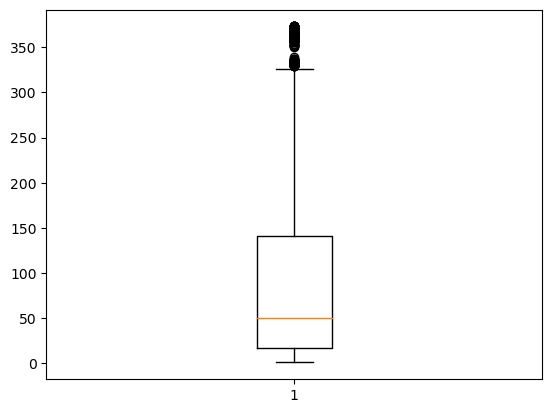

In [37]:
plt.boxplot(RFM1.Recency)
Q1 =RFM1.Recency.quantile(0.25)
Q3 = RFM1.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM1  = RFM1 [(RFM1.Recency >= Q1 - 1.5*IQR) & (RFM1.Recency <= Q3 + 1.5*IQR)]

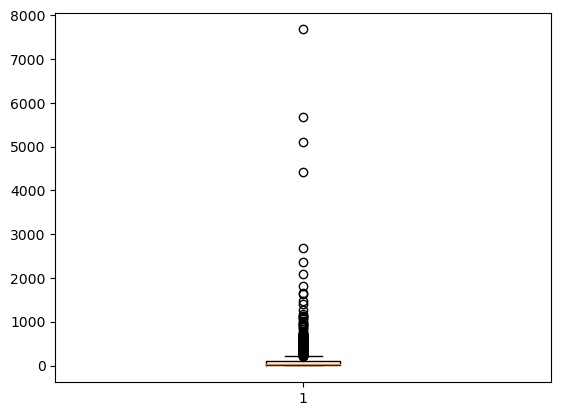

In [38]:
plt.boxplot(RFM1.Frequency)
Q1 = RFM1.Frequency.quantile(0.25)
Q3 = RFM1.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM1  = RFM1 [(RFM1.Frequency >= Q1 - 1.5*IQR) & (RFM1 .Frequency <= Q3 + 1.5*IQR)]

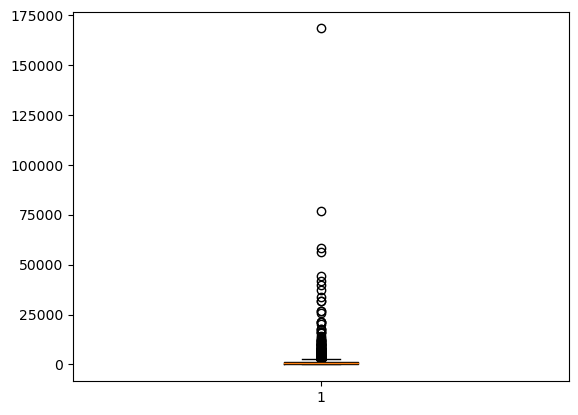

In [39]:
plt.boxplot(RFM1.Monetary)
Q1 = RFM1.Monetary.quantile(0.25)
Q3 = RFM1.Monetary.quantile(0.75)
IQR = Q3 - Q1
RFM1 = RFM1 [(RFM1 .Monetary >= (Q1 - 1.5*IQR)) & (RFM1.Monetary <= (Q3 + 1.5*IQR))]


# Transform Data using StandardScaler

In [40]:
# Apply K-Means ++
from sklearn.preprocessing import StandardScaler

Scaler=StandardScaler()
ScaledData=Scaler.fit(RFM1 )
ScaledData=Scaler.fit_transform(RFM1 )
ScaledData

array([[-0.20202766, -0.39180725,  1.54144551],
       [-0.82482118,  0.54139266,  1.48169697],
       [ 2.41148086, -0.70287388, -0.6606847 ],
       ...,
       [ 0.9768315 , -0.92506433, -1.04241898],
       [-0.94715562, -0.81396911, -0.89605088],
       [-0.55790967,  0.47473552,  1.60172093]])

# Elbow Method

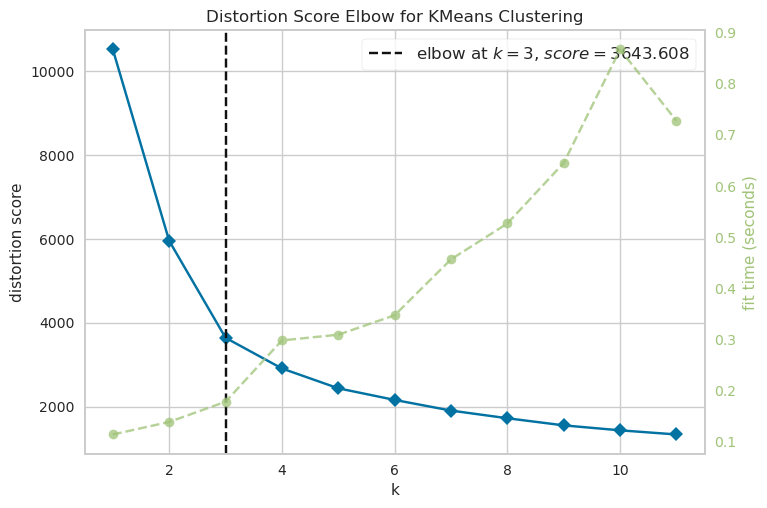

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
# Elbow Method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(ScaledData)  
visualizer.show()


# Apply K-Means ++

[1 1 0 ... 0 0 1]
 Our cluster centers are as follows
[[ 1.50799943 -0.56585643 -0.58903159]
 [-0.48846191 -0.33355471 -0.31624853]
 [-0.56744018  1.43842935  1.4239141 ]]


,Recency,Frequency,Monetary
cluster_pred,,,
0,888,888,888
1,1839,1839,1839
2,777,777,777


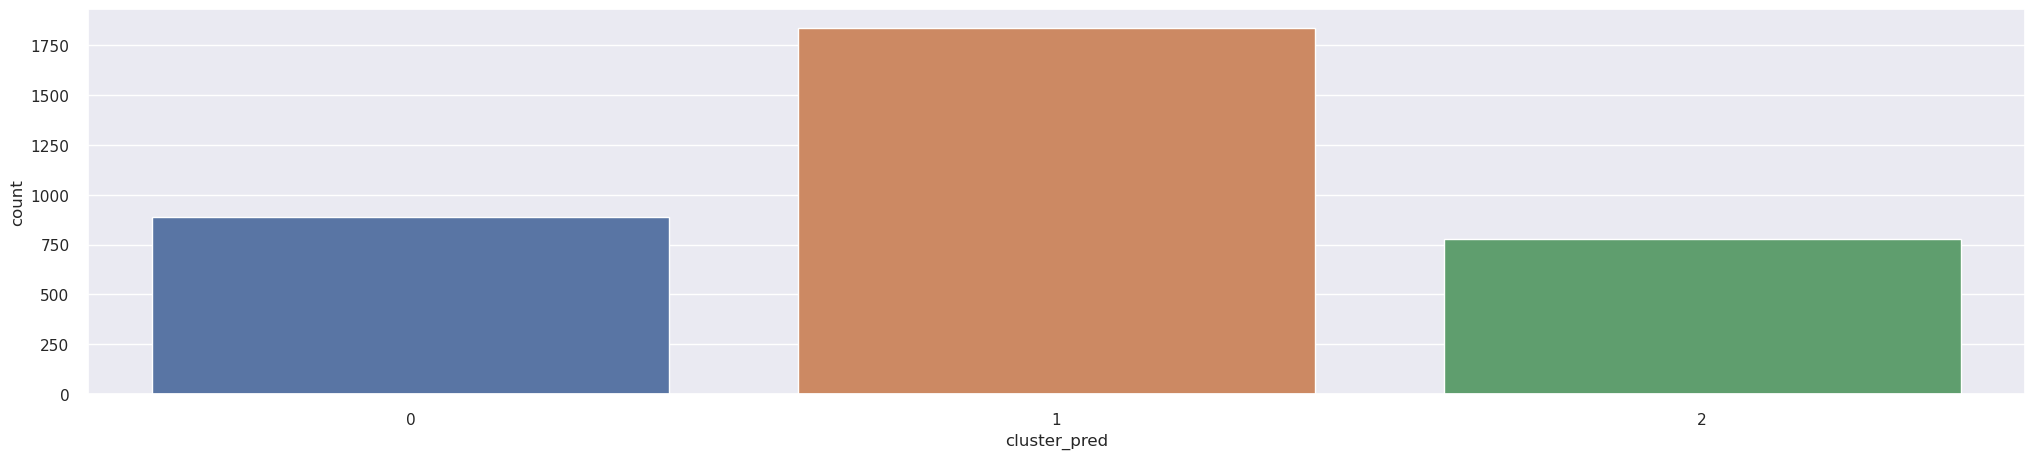

In [42]:
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++')
KMean_clust.fit(ScaledData)
predicted_clusters = KMean_clust.fit_predict(RFM1)
clusters_scaled = RFM1.copy()
clusters_scaled['cluster_pred']=KMean_clust.fit_predict(ScaledData)
print(predicted_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(KMean_clust.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()


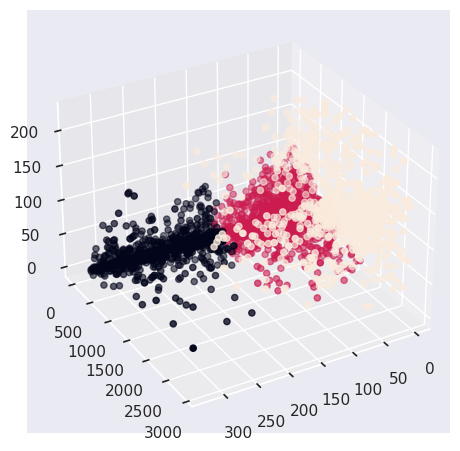

In [43]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['Recency']
yline=clusters_scaled['Frequency']
zline=clusters_scaled['Monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

In [44]:
import plotly.graph_objs as go
# create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=clusters_scaled['Recency'],
    y=clusters_scaled['Monetary'],
    z=clusters_scaled['Frequency'],
    mode='markers',
    marker=dict(
        color=clusters_scaled['cluster_pred'],
        size=5,
        opacity=0.8
    )
)])


# set the layout for the 3D scatter plot
fig.update_layout(scene=dict(
    xaxis_title='Recency',
    yaxis_title='Monetary',
    zaxis_title='Frequency'
))

# Validation Part 

In [45]:
#The score is higher when clusters are dense and well separated
from sklearn.metrics import calinski_harabasz_score
print(calinski_harabasz_score(ScaledData, KMean_clust.labels_))


3299.784641093393


In [46]:
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(ScaledData,KMean_clust.labels_))


0.821475920088635


Silhouette Score: 0.438


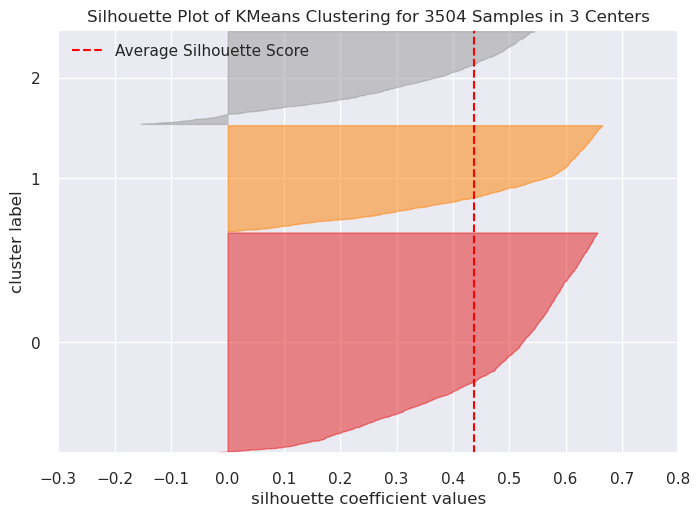

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3504 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [47]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(ScaledData, KMean_clust.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(ScaledData)   
visualizer.poof()

In [48]:
RFM1['cluster']= clusters_scaled['cluster_pred']
RFM1['level']=RFM['RFM_Loyalty_Level']
RFM1.head(10)



,Recency,Frequency,Monetary,cluster,level
2,74,31,1797.24,2,Gold
3,18,73,1757.55,2,Platinum
4,309,17,334.40,0,Bronze
5,35,85,2506.04,2,Platinum
6,203,4,89.00,0,Bronze
7,231,58,1079.40,0,Gold
8,213,13,459.40,0,Bronze
9,22,59,2811.43,2,Platinum
11,1,19,1168.06,1,Gold
13,51,129,2662.06,2,Platinum


In [49]:
RFM1.groupby(['cluster','level']).size()


cluster  level   
0        Platinum      0
         Gold         63
         Silver      326
         Bronze      499
1        Platinum    107
         Gold        965
         Silver      606
         Bronze      161
2        Platinum    537
         Gold        240
         Silver        0
         Bronze        0
dtype: int64

In [50]:
# Group the data by country and customer ID
country_data = E_data.groupby('Country')['CustomerID'].nunique().reset_index()
country_data.columns = ['Country', 'Customer Count']
country_data.loc[country_data['Customer Count'] <  20, 'Country'] = 'Other countries'
fig = px.pie(country_data,  values='Customer Count',names='Country',title='Customers grouped by Country')
fig.show()

In [51]:
#Monetary and customer 
# Group data by country and calculate total revenue and customer count
Country_Revenue= E_data.groupby(by='Country', as_index=False)['TotalAmount'].sum()
Country_Revenue.head()
Country_Revenue.columns = ['Country', 'TotalAmount']
Country_Revenue.loc[Country_Revenue['TotalAmount'] < 30000, 'Country'] = 'Other countries'
fig = px.pie(Country_Revenue,  values='TotalAmount',names='Country',title='Revenue Across Countries')
fig.show()

# Identify Products for STP Modeling

In [52]:
E_data['Description'].value_counts().nunique()

515

In [53]:
E_data['Description'].value_counts().head(20)

WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1714
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1390
LUNCH BAG RED RETROSPOT               1303
SET OF 3 CAKE TINS PANTRY DESIGN      1152
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1078
PACK OF 72 RETROSPOT CAKE CASES       1050
SPOTTY BUNTING                        1014
PAPER CHAIN KIT 50'S CHRISTMAS        1003
LUNCH BAG SPACEBOY DESIGN              993
HEART OF WICKER SMALL                  979
LUNCH BAG CARS BLUE                    977
NATURAL SLATE HEART CHALKBOARD         972
LUNCH BAG PINK POLKADOT                941
LUNCH BAG SUKI DESIGN                  915
REX CASH+CARRY JUMBO SHOPPER           897
ALARM CLOCK BAKELIKE RED               886
Name: Description, dtype: int64

In [54]:
product_M=E_data.groupby(by=['Description','Country'])['TotalAmount'].count()
product_M.head(60)

Description                       Country             
 4 PURPLE FLOCK DINNER CANDLES    EIRE                      1
                                  United Kingdom           36
 50'S CHRISTMAS GIFT BAG LARGE    EIRE                      1
                                  France                    1
                                  Germany                   5
                                  Portugal                  3
                                  Spain                     1
                                  United Kingdom           98
 DOLLY GIRL BEAKER                Australia                 1
                                  Austria                   1
                                  Belgium                   5
                                  Cyprus                    1
                                  EIRE                      2
                                  France                    9
                                  Germany                   7
               

In [55]:
Product=E_data['Description']
Product.count().sum()

392732

# Dashboard Code

In [56]:
import streamlit as st

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
st.set_page_config(page_title="E-commerce Dashboard",layout='wide',page_icon="chart_with_upwards_trend")
#st.title("E-commerce Dashboard 📈")
# use streamlit

with open('styles.css') as f:
    st.markdown(f'<style>{f.read()}</style>', unsafe_allow_html=True)


st.sidebar.header('E-commerce Dashboard 📈')
st.sidebar.subheader('Know Your Customers')
st.sidebar.image('market-segmentation.png')

st.sidebar.title('You got 450 :blue[Customers] with the highest RFM Score')
import plotly.figure_factory as ff
hist_data=[Frequency_Plot,Monetary_Plot]
group_labels=['Frequency','Monetary']
figure=ff.create_distplot(hist_data,group_labels,bin_size=[.1, .25, .5])


#First Row
st.markdown('### Metrics')
c1,c2,c3=st.columns(3)
c1.markdown('### Highest Revenue')
c1.markdown('### $7 Milion')
c2.markdown("### Highest Sales")
c2.markdown("### United Kingdom")
c2.markdown("### Netherlands")
c3.markdown("### Year")
c3.markdown('### 2017-2018')



#Second Row
tab4,tab5,tab6,tab17=st.tabs(['Customers Across Countries','Revenue Across Countries','Clusters Description','Product Across Countries'])
with tab4:
  st.plotly_chart(fig_country_customer,use_container_width=True,theme="streamlit")
with tab5:
  st.plotly_chart(fig_cou_revenue,use_container_width=True,theme="streamlit")
with tab6:
  st.dataframe(Combine)
with tab17:
  st.dataframe(product_M)



#Third Row
tab1,tab2=st.tabs(['Segments','Clusters '])
with tab1:
    st.plotly_chart(fig_loyalty,use_container_width=True,theme="streamlit")
with tab2:
    st.plotly_chart(fig_clusters,use_container_width=True,theme="streamlit")



#Fourth Row
t,a,b=st.tabs(['Recency','Frequency and Monetary','Clusters Count'])
with t:
    st.plotly_chart(fig1, use_container_width=True)
with a:
    st.plotly_chart(figure, use_container_width=True)
with b:
    st.plotly_chart(fig_cluster_pred,use_container_width=True,theme="streamlit")



